In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:



train_dir = '/content/gdrive/My Drive/cervical/train'
val_dir = '/content/gdrive/My Drive/cervical/val'
test_dir = '/content/gdrive/My Drive/cervical/test'

input_shape = (224, 224, 3)
num_classes = 5


batch_size = 32
num_epochs = 10


train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=50,
    zoom_range=[0.5, 1.0]
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    interpolation='bilinear',
    classes=["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    interpolation='bilinear',
    classes=["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
)

# ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Adding custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[:-100]:
    layer.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

#  early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#  checkpoint callback
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_accuracy', save_best_only=True)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping, checkpoint]
)



Found 8175 images belonging to 5 classes.
Found 1749 images belonging to 5 classes.
Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.9445 - accuracy: 0.6934 - precision_1: 0.7800 - recall_1: 0.5747

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 1420s 5s/step - loss: 0.9445 - accuracy: 0.6934 - precision_1: 0.7800 - recall_1: 0.5747 - val_loss: 5.4204 - val_accuracy: 0.6846 - val_precision_1: 0.7550 - val_recall_1: 0.5955
Epoch 2/10
255/255 [==============================] - 435s 2s/step - loss: 0.5484 - accuracy: 0.8070 - precision_1: 0.8565 - recall_1: 0.7544 - val_loss: 0.6616 - val_accuracy: 0.7946 - val_precision_1: 0.8286 - val_recall_1: 0.7552
Epoch 3/10
255/255 [==============================] - 422s 2s/step - loss: 0.4504 - accuracy: 0.8422 - precision_1: 0.8744 - recall_1: 0.8082 - val_loss: 0.8527 - val_accuracy: 0.7309 - val_precision_1: 0.7600 - val_recall_1: 0.6927
Epoch 4/10
255/255 [==============================] - 443s 2s/step - loss: 0.4078 - accuracy: 0.8537 - precision_1: 0.8808 - recall_1: 0.8207 - val_loss: 0.5396 - val_accuracy: 0.8304 - val_precision_1: 0.8556 - val_recall_1: 0.8194
Epoch 5/10
255/255 [==============================] - 426s 2s/step - loss: 0.3

In [ ]:
# Evaluating the model on the test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    interpolation='bilinear',
    classes=["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
)

test_results = model.evaluate(test_generator)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Found 1757 images belonging to 5 classes.
55/55 [==============================] - 461s 9s/step - loss: 0.4077 - accuracy: 0.8657 - precision_1: 0.8778 - recall_1: 0.8583
Test Loss: 0.4077448844909668
Test Accuracy: 0.8656801581382751


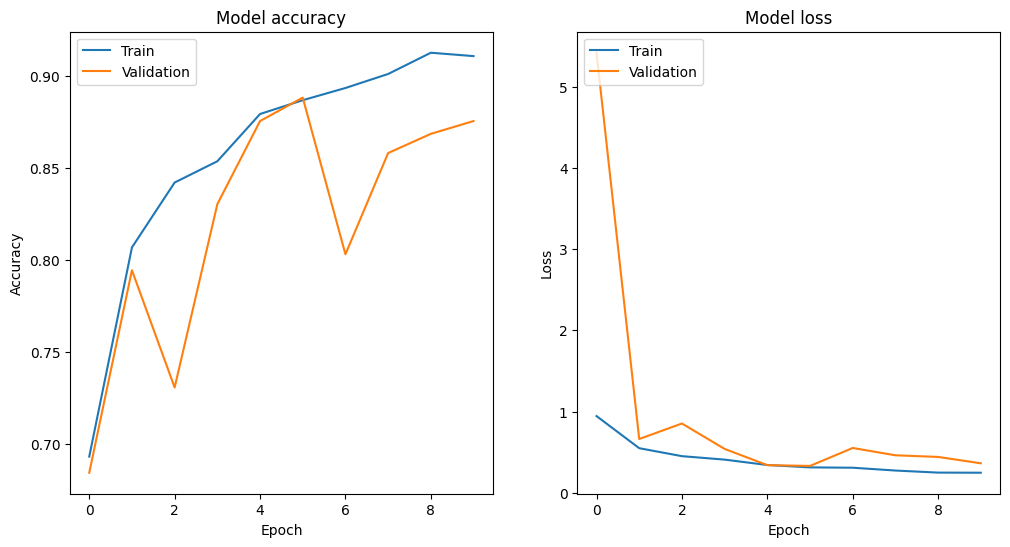

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


55/55 [==============================] - 55s 994ms/step


<Figure size 2000x800 with 0 Axes>

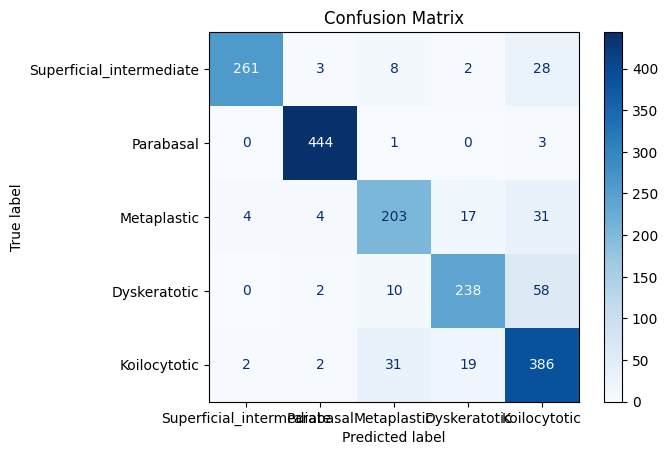

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.load_weights('best_resnet_model.h5')

true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(20, 8))

# Plot the confusion matrix
class_names = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
display = ConfusionMatrixDisplay(confusion, display_labels=class_names)
display.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report


true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)


class_names = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


55/55 [==============================] - 57s 1s/step
                          precision    recall  f1-score   support

Superficial_intermediate       0.98      0.86      0.92       302
               Parabasal       0.98      0.99      0.98       448
             Metaplastic       0.80      0.78      0.79       259
            Dyskeratotic       0.86      0.77      0.82       308
            Koilocytotic       0.76      0.88      0.82       440

                accuracy                           0.87      1757
               macro avg       0.88      0.86      0.86      1757
            weighted avg       0.88      0.87      0.87      1757



In [ ]:
loaded_model = tf.keras.models.load_model('best_resnet_model.h5')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def predict_image(path):
    global loaded_model

    # Load and preprocess the image
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    input_arr = np.array([img_array])
    input_arr.shape

    # Make prediction
    predictions = loaded_model.predict(input_arr)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Define your class labels
    class_labels = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    # Display image
    plt.imshow(input_arr[0], vmin=0, vmax=1)
    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.show()


1/1 [==============================] - 0s 40ms/step


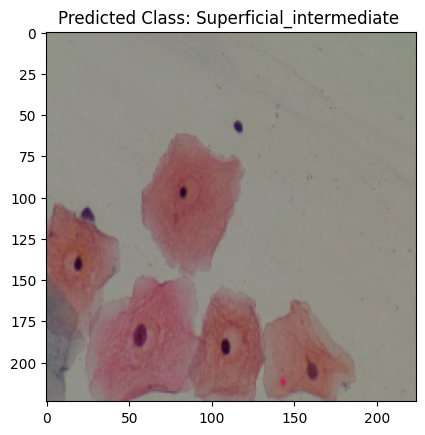

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/6.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 30ms/step


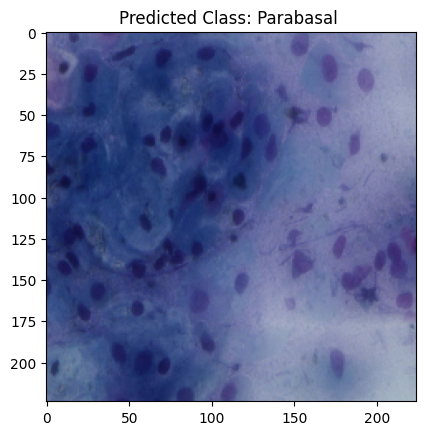

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/7.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 28ms/step


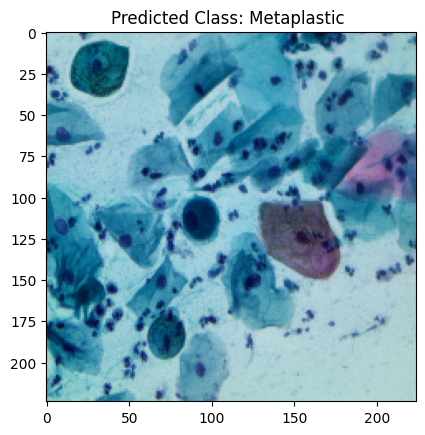

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/8.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 29ms/step


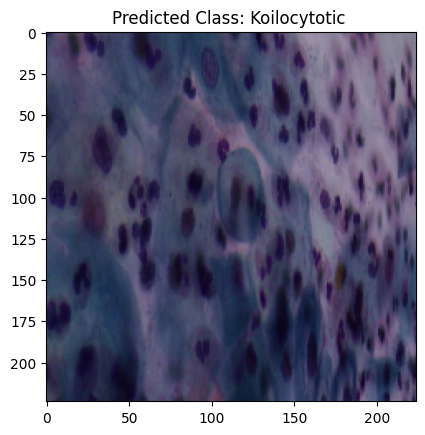

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/9.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 25ms/step


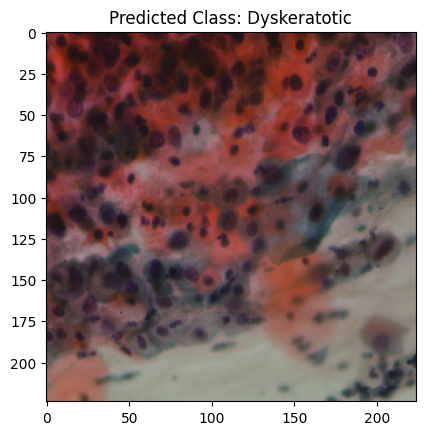

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/10.jpg'
predict_image(image_path)